Students:

- ...
- ...
- ...

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [193]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [194]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [195]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 9


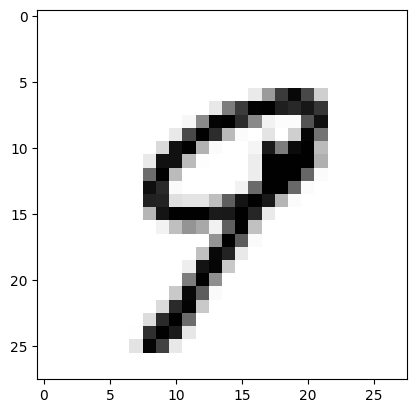

In [196]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [197]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g

        # run the backward 
        self.d( self.backptr, self.gradient )
        for o in self.backptr:
            if isinstance(o, Tensor) and not isinstance(o, Parameter) and o.require_grad:
                o.backward()
    
    
    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [198]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [199]:
# Here is an exemple with the ReLU
def relu(x):
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [200]:
def tanh(x): 
    v=np.tanh(x.data)
    output=Tensor(v,require_grad=x.require_grad)
    output.d=backward_tanh
    output.backptr=[x]
    return output

def backward_tanh(backptr, g):
    x, = backptr
    if x.require_grad:
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [201]:
def affine_transform(W, b, x):
    """
    Input:
    - W: a Parameter of shape (D, M)
    - b: a Parameter of shape (M,)
    - x: a Tensor of shape (D,)
    Output:
    - a Tensor of shape (M,)
    """
    v = W.data @ x.data + b.data
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    
    return output


def backward_affine_transform(backptr, g):

    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1, 1) @ x.data.reshape(1, -1))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        # (10, 100) (10,) (100,) (10,)
        #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
        x.accumulate_gradient(W.data.T @ g)

In [202]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    x = x - np.max(x)
    x = np.exp(x)
    x = x / np.sum(x)
    return x

def nll(x, gold):
    
    v = -np.log(_softmax(x.data)[gold])
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_nll
    output.backptr = [x, gold]
    
    return output

def backward_nll(backptr, g):
    x, gold = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        ft=_softmax(x.data)
        ft[gold] -= 1
        x.accumulate_gradient(g * ft)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [203]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [204]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), np.sqrt(6. / (W.shape[0] + W.shape[1])), W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / W.shape[1]), np.sqrt(6. / W.shape[1]), W.shape)

In [269]:
# simple gradient descent optimizer
class SGD:
    def __init__(self, params, lr=0.1,use_weight_decay=False,weight_decay=0.001):
        self.params = params
        self.lr = lr
        self.use_weight_decay=use_weight_decay
        self.weight_decay=weight_decay
    def step(self):
        for p in self.params:
            if self.use_weight_decay:
                if p.name=='W':
                    p.data[:] = p.data - self.lr * (p.gradient+self.weight_decay*p.data)
            else:
                p.data[:] = p.data - self.lr * p.gradient
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [206]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return  affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [207]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [283]:
# function to get accuracy

def get_accuracy(network, data):
    n_data = data[0].shape[0]
    correct = 0
    for x, y in zip(data[0], data[1]):
        y_hat = network.forward(x)
        correct += int(np.argmax(y_hat.data) == y)
    return correct / n_data

In [271]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10, use_weight_decay=False, weight_decay=0.001):

    # Number of training samples
    n_training = train_data[0].shape[0]
    n_dev = dev_data[0].shape[0]

    # Array containing some stats
    avg_losses = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    dev_acc_epoch = np.zeros(n_epochs)
    dev_acc  =[]
    total_acc_values=[]
     
    # parameters to store score and parameters of the best model on dev
    best_dev_accuracy = 0
    best_params = None  
    

    # For each epoch...
    for epoch_i in range(n_epochs ):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, n_epochs ))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        train_loss = 0
        train_correct = 0

        # shuffle the data before each epoch
        indices = np.random.permutation(n_training)
        train_data_shuffled = (train_data[0][indices], train_data[1][indices])   

        for i, (x, y) in enumerate (zip (train_data_shuffled[0], train_data_shuffled[1])):
            # forward pass
            y_hat = network.forward(Tensor(x))
            if use_weight_decay: 
                for param in network.parameters():
                    if param.name=="W":
                        loss = nll(y_hat, y).data + weight_decay * param.data.T.dot(param.data)*0.5
                #loss = nll(y_hat, y) + weight_decay * network.W.data.dot(network.W.data)*0.5
            else: 
                loss= nll(y_hat, y)
            loss = nll(y_hat, y)
            train_loss += loss.data

            # backward pass
            optimizer.zero_grad()
            loss.backward(1.0)
            optimizer.step()

            # compute accuracy on train set
            train_correct += int(np.argmax(y_hat.data) == y)

            # evaluate the model on the dev data after 10000 training examples (5 evaluation per epoch on dev)
            if (i+1)% 10000 == 0:
                dev_correct = 0
                for x, y in zip(dev_data[0], dev_data[1]):
                    y_hat = network.forward(Tensor(x))
                    dev_correct += int(np.argmax(y_hat.data) == y)

                dev_accuracy = dev_correct / n_dev  
                print(f" current Dev accuracy: {dev_accuracy:.3f}")
                dev_acc.append(dev_accuracy)
                dev_acc.append(dev_accuracy)

                # check if dev accuracy has improved and update best parameters
                if dev_accuracy > best_dev_accuracy:
                    best_dev_accuracy = dev_accuracy
                    best_params = (network.W, network.b)

        
        # Compute avg loss, avg train accuracy and dev accuracy
        avg_losses[epoch_i] = train_loss/ n_training
        train_acc[epoch_i]  = train_correct/ n_training
        total_acc_values.append(dev_acc)

        dev_acc_epoch[epoch_i] = max(dev_acc)
            # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
            
        print("---------------------------------")
        print(f"Avg_loss: {avg_losses[epoch_i]:.3f}")
        print(f"Train accuracy: {train_acc[epoch_i]}")
        print(f"Best dev accuracy: {best_dev_accuracy:.3f}")
        print("Dev accuracy epoch: {:}".format(dev_acc_epoch[epoch_i]))
        print("Training epcoh took: {:}".format(training_time))
        print(" ---------------------------------")
        dev_acc = []
   
    return {"losses": avg_losses, "train_acc": train_acc, "dev_acc": dev_acc_epoch}, best_params
    

In [270]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)

history, best_params =training_loop(network, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.903
 current Dev accuracy: 0.906
 current Dev accuracy: 0.909
 current Dev accuracy: 0.913
 current Dev accuracy: 0.918
---------------------------------
avg_loss: 0.376
Train accuracy: 0.89136
Dev accuracy: 0.918
 best dev accuracy: 0.918
dev accuracy epoch: 0.9177
training epcoh took: 0:00:12
 ---------------------------------

======== Epoch 2 / 5 ========
Training...


KeyboardInterrupt: 

In [210]:
def plot_loss_acc(avg_losses, train_acc, dev_acc_epoch):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(avg_losses, label='train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(train_acc, label='train accuracy')
    ax[1].plot(dev_acc_epoch, label='dev accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

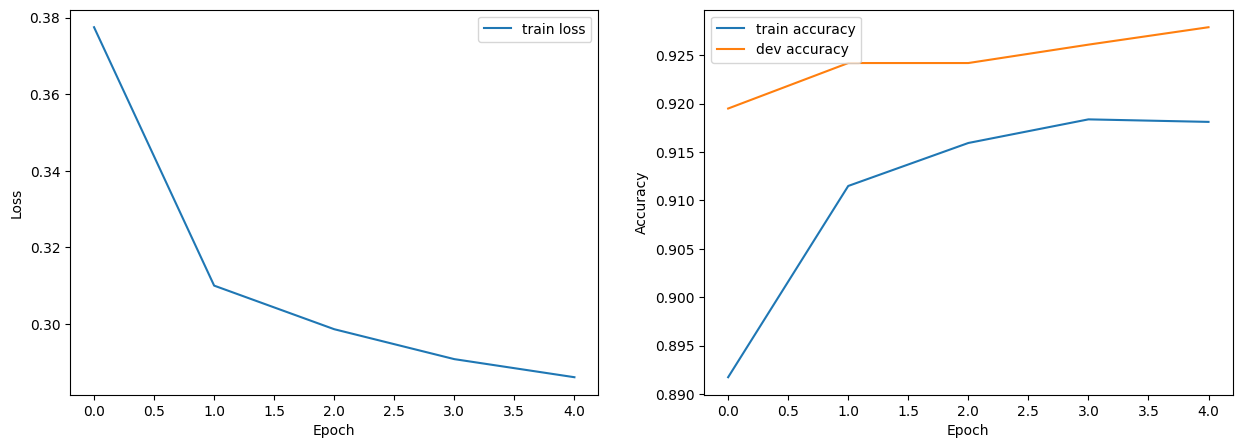

In [211]:
plot_loss_acc(history["losses"], history["train_acc"], history["dev_acc"])

In [284]:
n_test = test_data[0].shape[0]
network.W, network.b = best_params

print("Test_accuracy=%.4f" % get_accuracy(network,test_data))

Test_accuracy=0.9187


After you finished the linear network, you can move to a deep network!

In [251]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False):
        self.W = ModuleList()
        self.b = ModuleList()
        self.activation = relu if not use_tanh else tanh
        self.init= glorot_init if tanh else kaiming_init
    
        for i in range(n_layers):
            if i==0:
                self.W.append(Parameter(np.ndarray((hidden_dim, dim_input)), name=f"W"))
                self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b_{i}"))
            else:
                self.W.append(Parameter(np.ndarray((hidden_dim, hidden_dim)), name=f"W"))
                self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b_{i}"))
        
        if n_layers == 0:
            print('yes yes ')
            self.W.append(Parameter(np.ndarray((dim_output, dim_input)), name=f"W"))
            self.b.append(Parameter(np.ndarray((dim_output,)), name=f"b"))
    
        self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name=f"W")
        self.output_bias = Parameter(np.ndarray((dim_output,)), name=f"b")
        
        self.init_parameters()
        
    def init_parameters(self):
         for w, b in zip(self.W, self.b):
            self.init(w.data)
            zero_init(b.data)

         self.init(self.output_proj.data)
         zero_init(self.output_bias.data)
        
       
    def forward(self, x):
        for w, b in zip(self.W, self.b):
            x = self.activation(affine_transform(w, b, x))
        return affine_transform(self.output_proj, self.output_bias, x)

In [272]:
dim_input = 28*28
dim_output = 10

network2= DeepNetwork(dim_input, dim_output, 100, 2, use_tanh=True)
optimizer = SGD(network2.parameters(), 0.01,use_weight_decay=True)

history2, best_params2=training_loop(network2, optimizer, train_data, dev_data, n_epochs=5,use_weight_decay=True)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.922
 current Dev accuracy: 0.937
 current Dev accuracy: 0.945
 current Dev accuracy: 0.953
 current Dev accuracy: 0.949
---------------------------------
avg_loss: 0.272
Train accuracy: 0.91792
Dev accuracy: 0.953
 best dev accuracy: 0.953
dev accuracy epoch: 0.9533
training epcoh took: 0:13:12
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.957
 current Dev accuracy: 0.961
 current Dev accuracy: 0.953
 current Dev accuracy: 0.961
 current Dev accuracy: 0.960
---------------------------------
avg_loss: 0.150
Train accuracy: 0.95412
Dev accuracy: 0.961
 best dev accuracy: 0.961
dev accuracy epoch: 0.9609
training epcoh took: 0:13:08
 ---------------------------------

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.965
 current Dev accuracy: 0.961
 current Dev accuracy: 0.959
 current Dev accuracy: 0.959
 current Dev accuracy: 0.962
--------------

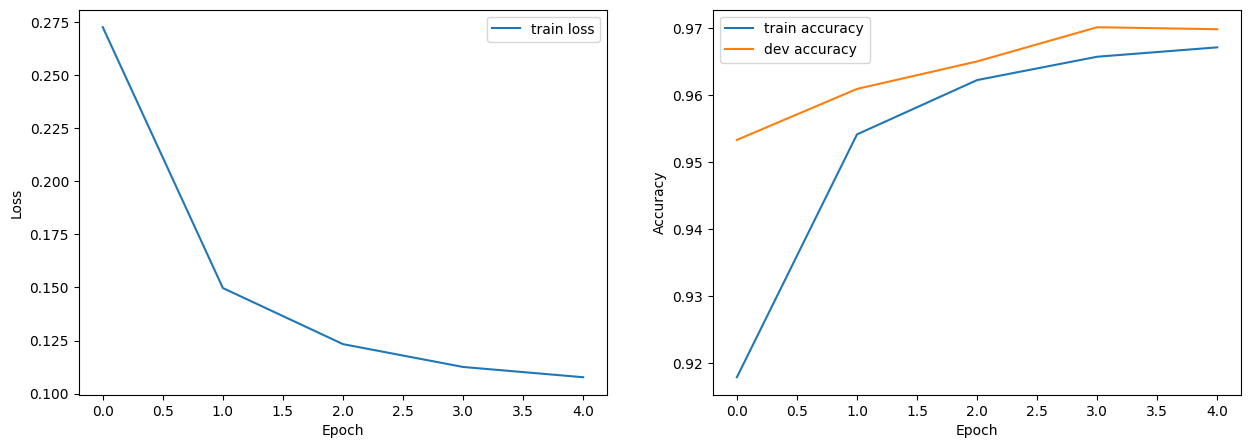

In [277]:
# plot with the weight decay
plot_loss_acc(history2["losses"], history2["train_acc"], history2["dev_acc"])

In [278]:
network2.W, network2.b= best_params2[0], best_params2[1]
get_accuracy(network2, test_data)

0.9668

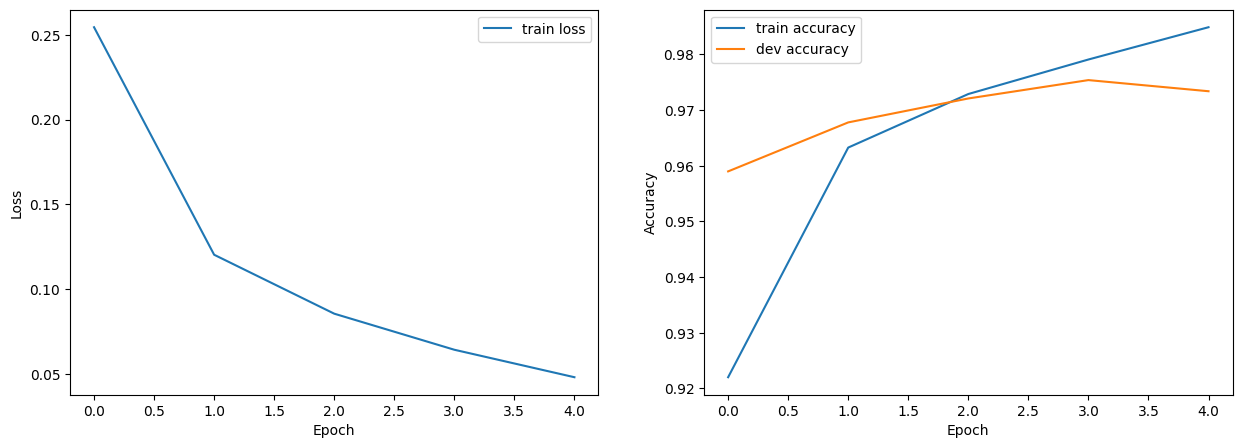

In [215]:
plot_loss_acc(history2["losses"], history2["train_acc"], history2["dev_acc"])

In [216]:
dim_input = 28*28
dim_output = 10

network3 = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network3.parameters(), 0.01)

history3, best_params3=training_loop(network3, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.928
 current Dev accuracy: 0.944
 current Dev accuracy: 0.959
 current Dev accuracy: 0.961
 current Dev accuracy: 0.962
---------------------------------
avg_loss: 0.250
Train accuracy: 0.92412
Dev accuracy: 0.962
 best dev accuracy: 0.962
dev accuracy epoch: 0.9616
training epcoh took: 0:01:24
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.953
 current Dev accuracy: 0.964
 current Dev accuracy: 0.963
 current Dev accuracy: 0.966
 current Dev accuracy: 0.960
---------------------------------
avg_loss: 0.117
Train accuracy: 0.96302
Dev accuracy: 0.966
 best dev accuracy: 0.966
dev accuracy epoch: 0.9659
training epcoh took: 0:01:24
 ---------------------------------

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.970
 current Dev accuracy: 0.970
 current Dev accuracy: 0.967
 current Dev accuracy: 0.967
 current Dev accuracy: 0.969
--------------

In [276]:
network3.W, network3.b= best_params3[0], best_params3[1]
def get_accuracy(network, data):
    n_data = data[0].shape[0]
    correct = 0
    for x, y in zip(data[0], data[1]):
        y_hat = network.forward(x)
        correct += int(np.argmax(y_hat.data) == y)
    return correct / n_data

get_accuracy(network3, test_data)

0.9753

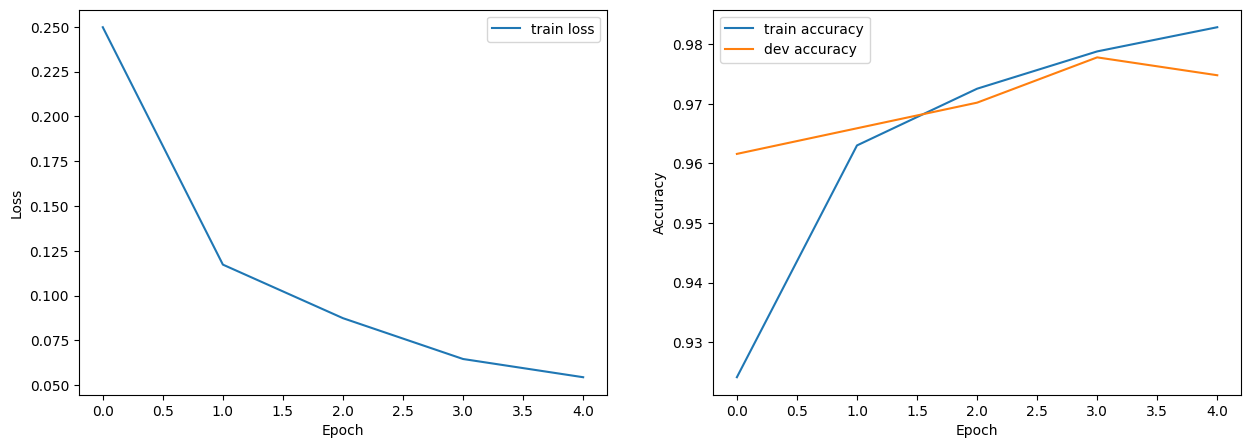

In [217]:
plot_loss_acc(history3["losses"], history3["train_acc"], history3["dev_acc"])

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [218]:
class SGD_momentum:
    def __init__(self, params, lr=0.1, momentum=0.9):
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.velocities = []
        
        for p in self.params:
            self.velocities.append(np.zeros_like(p.data))        
        
    def step(self):
        for i, p in enumerate(self.params):
            v = self.velocities[i]
            v[:] = self.momentum * v + (1 - self.momentum) * p.gradient
            p.data[:] = p.data - self.lr * v
        
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

In [219]:
dim_input = 28*28
dim_output = 10

model = DeepNetwork(dim_input, dim_output, 100, 2, use_tanh=True)
optimizer = SGD_momentum(model.parameters(), lr=0.01, momentum=0.99)
history_mod1, best_params_mod1=training_loop(model, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.919
 current Dev accuracy: 0.939
 current Dev accuracy: 0.949
 current Dev accuracy: 0.947
 current Dev accuracy: 0.960
---------------------------------
avg_loss: 0.260
Train accuracy: 0.9197
Dev accuracy: 0.960
 best dev accuracy: 0.960
dev accuracy epoch: 0.9596
training epcoh took: 0:01:46
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.958
 current Dev accuracy: 0.965
 current Dev accuracy: 0.966
 current Dev accuracy: 0.967
 current Dev accuracy: 0.968
---------------------------------
avg_loss: 0.123
Train accuracy: 0.96186
Dev accuracy: 0.968
 best dev accuracy: 0.968
dev accuracy epoch: 0.9678
training epcoh took: 0:01:46
 ---------------------------------

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.970
 current Dev accuracy: 0.964
 current Dev accuracy: 0.968
 current Dev accuracy: 0.971
 current Dev accuracy: 0.968
---------------

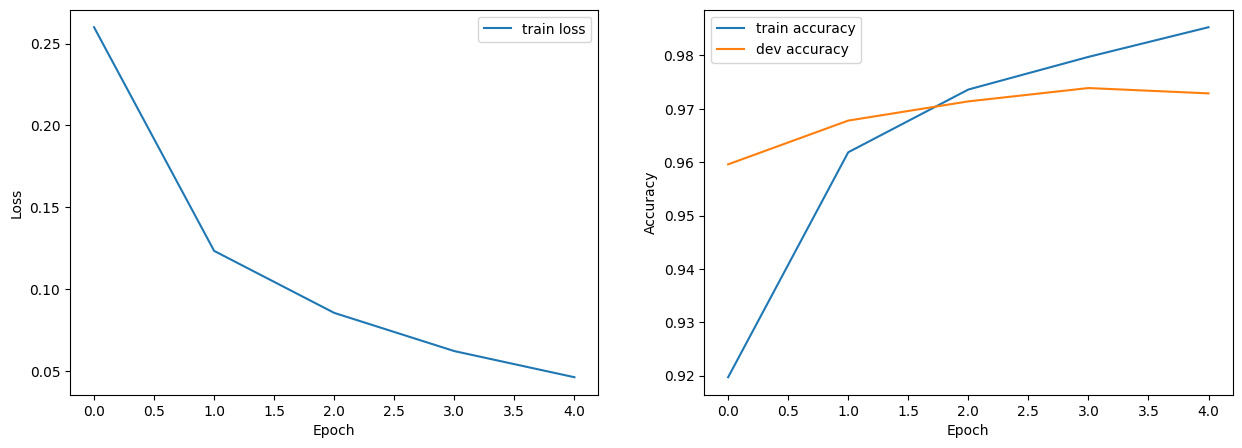

In [220]:
plot_loss_acc(history_mod1["losses"], history_mod1["train_acc"], history_mod1["dev_acc"])

In [221]:
dim_input = 28*28
dim_output = 10

model2 = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD_momentum(model2.parameters(), lr=0.01, momentum=0.99)
history_mod2, best_params_mod2=training_loop(model2, optimizer, train_data, dev_data, n_epochs=5)


======== Epoch 1 / 5 ========
Training...
 current Dev accuracy: 0.925
 current Dev accuracy: 0.941
 current Dev accuracy: 0.947
 current Dev accuracy: 0.942
 current Dev accuracy: 0.962
---------------------------------
avg_loss: 0.261
Train accuracy: 0.91944
Dev accuracy: 0.962
 best dev accuracy: 0.962
dev accuracy epoch: 0.9624
training epcoh took: 0:01:47
 ---------------------------------

======== Epoch 2 / 5 ========
Training...
 current Dev accuracy: 0.963
 current Dev accuracy: 0.960
 current Dev accuracy: 0.965
 current Dev accuracy: 0.962
 current Dev accuracy: 0.967
---------------------------------
avg_loss: 0.121
Train accuracy: 0.96352
Dev accuracy: 0.967
 best dev accuracy: 0.967
dev accuracy epoch: 0.9674
training epcoh took: 0:01:49
 ---------------------------------

======== Epoch 3 / 5 ========
Training...
 current Dev accuracy: 0.965
 current Dev accuracy: 0.963
 current Dev accuracy: 0.970
 current Dev accuracy: 0.968
 current Dev accuracy: 0.971
--------------

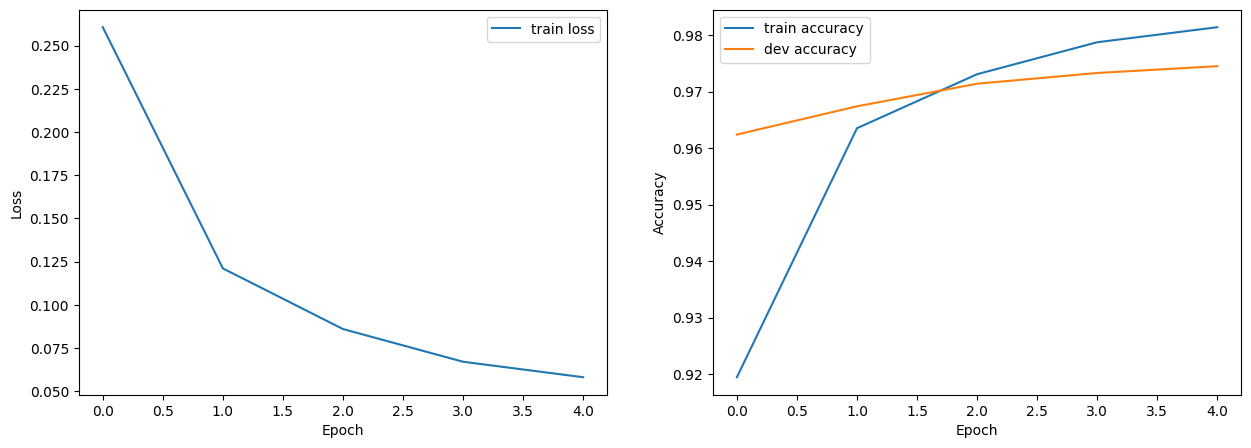

In [222]:
plot_loss_acc(history_mod2["losses"], history_mod2["train_acc"], history_mod2["dev_acc"])